## Variational Auto-Encoder with DC-GAN-like encoder and decoder 

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
from PIL import Image

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_reconstructions(x, x_hat):
    imsize = 32
    n_rows = 10
    x = np.reshape(x[:50], [5, 10, imsize, imsize])
    x_hat = np.reshape(x_hat[:50], [5, 10, imsize, imsize])
    canvas = np.zeros([imsize * 10, imsize * 10])
    for i in range(5):
        canvas[2*i*imsize:(2*i+1)*imsize, :] = np.transpose(x[i], [0, 2, 1]).reshape([imsize * 10, imsize]).T
        canvas[(2*i+1)*imsize:(2*i+2)*imsize, :] = np.transpose(x_hat[i], [0, 2, 1]).reshape([imsize * 10, imsize]).T
    plt.imshow(canvas, cmap='Greys_r')
    plt.title('Reconstruction')
    plt.show()

In [3]:
def render_images(np_x, n_rows=10, figsize=[4, 4]):
    plt.figure(figsize=figsize)
    np_x = np_x.reshape((n_rows,n_rows,32,32))
    np_x = np.concatenate(np.split(np_x,n_rows,axis=0),axis=3)
    np_x = np.concatenate(np.split(np_x,n_rows,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    plt.imshow(x_img, cmap='Greys_r')
    plt.title('Generation')
    plt.show()

In [4]:
from skimage.transform import resize
def resize_images(X):
    X_resized = np.zeros([X.shape[0], 32, 32, X.shape[-1]])
    for i, x in enumerate(X):
        X_resized[i] = resize(x, (32, 32))
    return X_resized

In [5]:
def batch_generator(X, batch_size=100):
    n_samples = X.shape[0]
    n_batches = int(np.ceil(n_samples/batch_size))
    while True:
        np.random.shuffle(X)
        for b in range(n_batches):
            batch = X[b*batch_size:(b+1)*batch_size]
            yield batch

In [6]:
# DC-GAN-like encoder and decoder
def encoder(x, z_dim=32, ndf=64, training=True, reuse=False):
    imwidth, imheight, nc = x.get_shape()[1:]
    assert imwidth == imheight and imwidth % 16 == 0
    with tf.variable_scope('encoder', reuse=reuse):
        z = tf.layers.conv2d(x, ndf, 4, 2, padding='same', activation=None, use_bias=False)
        z = tf.nn.leaky_relu(z, 0.2)
        cur_size, nchannels = imwidth // 2, ndf
        while cur_size > 4:
            nchannels *= 2
            z = tf.layers.conv2d(z, nchannels, 4, 2, padding='same', activation=None, use_bias=False)
            z = tf.layers.batch_normalization(z, epsilon=1e-5, momentum=0.9, training=training)
            z = tf.nn.leaky_relu(z, 0.2)
            cur_size = cur_size // 2
        z = tf.layers.conv2d(z, 256, 4, 1, padding='valid', activation=None, use_bias=False)
        z = tf.nn.leaky_relu(z, 0.2)
        z = tf.layers.flatten(z)
        mu = tf.layers.dense(z, z_dim, activation=None)
        sigma = 1e-6 + tf.nn.softplus(tf.layers.dense(z, z_dim, activation=None))
    return mu, sigma

def decoder(z, imsize=32, nc=1, ngf=64, training=True, reuse=False):
    cur_size, nchannels = 4, ngf
    while cur_size != imsize:
        cur_size *= 2
        nchannels *= 2
    cur_size = 4
    with tf.variable_scope('decoder', reuse=reuse):
        z = tf.layers.dense(z, 256, activation=tf.nn.relu)
        z = tf.reshape(z, [-1, 1, 1, 256])
        z = tf.layers.conv2d_transpose(z, nchannels, 4, 1, padding='valid', activation=None, use_bias=False)
        z = tf.layers.batch_normalization(z, epsilon=1e-5, momentum=0.9, training=training)
        z = tf.nn.relu(z)
        while cur_size < imsize // 2:
            nchannels = nchannels // 2
            z = tf.layers.conv2d_transpose(z, nchannels, 4, 2, padding='same', activation=None, use_bias=False)
            z = tf.layers.batch_normalization(z, epsilon=1e-5, momentum=0.9, training=training)
            z = tf.nn.relu(z)
            cur_size *= 2
        z = tf.layers.conv2d_transpose(z, nc, 4, 2, padding='same', activation=None, use_bias=False)
        x_hat = tf.nn.sigmoid(z)
    return x_hat

In [7]:
train_data_file = 'train_X.npy'
test_data_file = 'test_X.npy'
if not (os.path.exists(train_data_file) and os.path.exists(test_data_file)):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=False)
    train_X = resize_images(mnist.train.images)
    test_X = resize_images(mnist.test.images)
    np.save(train_data_file, train_X)
    np.save(test_data_file, test_X)
train_X = np.load(train_data_file)
test_X = np.load(test_data_file)

In [8]:
batch_size = 100
nb_steps = 50000
z_dim = 32

In [9]:
x = tf.placeholder(tf.float32, [None, 32, 32, 1])
mu, sigma = encoder(x, z_dim=z_dim)
z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
x_hat = decoder(z)

In [10]:
loglikelihood = tf.reduce_mean(tf.reduce_sum(x * tf.log(x_hat + 1e-8) + (1 - x) * tf.log(1 - x_hat + 1e-8), [1, 2, 3]))
kl = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, [1]))
ELBO = loglikelihood - kl
loss = -ELBO

In [11]:
x_test = tf.placeholder(tf.float32, [None, 32, 32, 1])
z_test = encoder(x_test, z_dim=z_dim, reuse=True, training=False)[0]
x_recons = decoder(z_test, reuse=True, training=False)

In [12]:
z_noise = tf.placeholder(tf.float32, [None, z_dim])
x_fake = decoder(z_noise, reuse=True, training=False)

In [13]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_vae_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
init_op = tf.global_variables_initializer()

In [14]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [15]:
train_batches = batch_generator(train_X, batch_size)
test_batches = batch_generator(test_X, batch_size=50)

## Training, Reconstruction from Test Set, and Generation from $\mathcal{N}(\mathbf{0},\mathbf{I})$

Step: 1000 in 22.04s :: Loss: 151.253 => Recons.: 125.861, KL: 25.392
Step: 2000 in 21.75s :: Loss: 145.997 => Recons.: 121.673, KL: 24.324
Step: 3000 in 21.84s :: Loss: 146.766 => Recons.: 122.128, KL: 24.639
Step: 4000 in 22.08s :: Loss: 150.904 => Recons.: 125.695, KL: 25.209
Step: 5000 in 21.97s :: Loss: 146.158 => Recons.: 121.393, KL: 24.765
Step: 6000 in 19.43s :: Loss: 144.479 => Recons.: 120.205, KL: 24.274
Step: 7000 in 17.31s :: Loss: 147.982 => Recons.: 124.291, KL: 23.691
Step: 8000 in 17.27s :: Loss: 138.214 => Recons.: 115.742, KL: 22.472
Step: 9000 in 17.33s :: Loss: 144.128 => Recons.: 120.834, KL: 23.294
Step: 10000 in 17.41s :: Loss: 137.917 => Recons.: 115.170, KL: 22.748


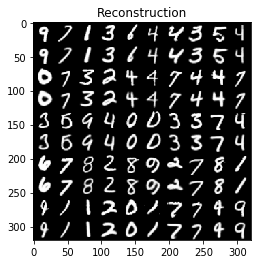

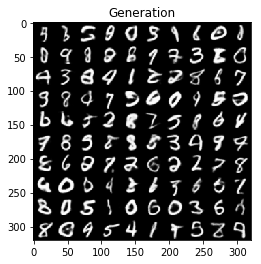

Step: 11000 in 17.39s :: Loss: 143.835 => Recons.: 119.680, KL: 24.154
Step: 12000 in 17.39s :: Loss: 141.967 => Recons.: 119.075, KL: 22.892
Step: 13000 in 18.89s :: Loss: 140.303 => Recons.: 116.494, KL: 23.809
Step: 14000 in 22.37s :: Loss: 136.482 => Recons.: 114.006, KL: 22.477
Step: 15000 in 22.34s :: Loss: 136.768 => Recons.: 113.701, KL: 23.066
Step: 16000 in 22.31s :: Loss: 140.024 => Recons.: 116.990, KL: 23.033
Step: 17000 in 21.64s :: Loss: 137.372 => Recons.: 114.072, KL: 23.300
Step: 18000 in 17.35s :: Loss: 139.259 => Recons.: 116.020, KL: 23.239
Step: 19000 in 17.31s :: Loss: 138.645 => Recons.: 115.773, KL: 22.872
Step: 20000 in 17.37s :: Loss: 139.968 => Recons.: 116.113, KL: 23.855


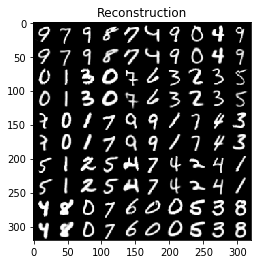

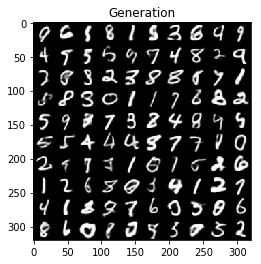

Step: 21000 in 17.49s :: Loss: 140.043 => Recons.: 117.232, KL: 22.811
Step: 22000 in 17.17s :: Loss: 140.132 => Recons.: 117.430, KL: 22.702
Step: 23000 in 17.33s :: Loss: 136.090 => Recons.: 113.912, KL: 22.178
Step: 24000 in 17.28s :: Loss: 141.187 => Recons.: 118.417, KL: 22.771
Step: 25000 in 21.16s :: Loss: 134.579 => Recons.: 112.382, KL: 22.197
Step: 26000 in 24.04s :: Loss: 134.639 => Recons.: 112.268, KL: 22.371
Step: 27000 in 24.04s :: Loss: 138.348 => Recons.: 115.782, KL: 22.566
Step: 28000 in 23.82s :: Loss: 134.387 => Recons.: 111.857, KL: 22.530
Step: 29000 in 24.07s :: Loss: 137.115 => Recons.: 114.827, KL: 22.288
Step: 30000 in 24.04s :: Loss: 140.266 => Recons.: 116.646, KL: 23.620


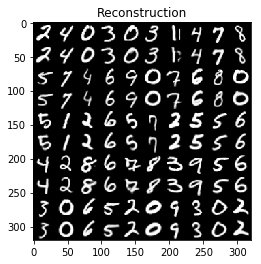

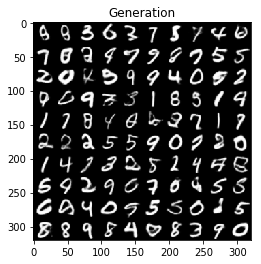

Step: 31000 in 24.24s :: Loss: 136.765 => Recons.: 113.983, KL: 22.782
Step: 32000 in 24.04s :: Loss: 137.268 => Recons.: 114.218, KL: 23.051
Step: 33000 in 23.84s :: Loss: 135.348 => Recons.: 113.206, KL: 22.142
Step: 34000 in 23.95s :: Loss: 136.555 => Recons.: 114.747, KL: 21.808
Step: 35000 in 23.99s :: Loss: 135.153 => Recons.: 113.176, KL: 21.977
Step: 36000 in 24.14s :: Loss: 137.505 => Recons.: 115.037, KL: 22.467
Step: 37000 in 24.08s :: Loss: 136.484 => Recons.: 113.909, KL: 22.575
Step: 38000 in 24.07s :: Loss: 135.945 => Recons.: 112.584, KL: 23.361
Step: 39000 in 23.85s :: Loss: 133.603 => Recons.: 111.847, KL: 21.756
Step: 40000 in 24.08s :: Loss: 133.943 => Recons.: 111.953, KL: 21.990


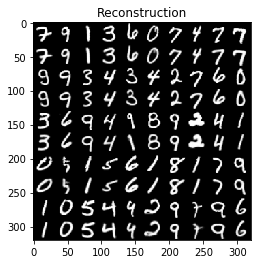

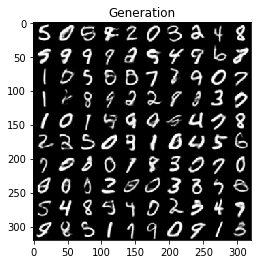

Step: 41000 in 23.56s :: Loss: 139.634 => Recons.: 116.678, KL: 22.956
Step: 42000 in 19.87s :: Loss: 138.007 => Recons.: 115.377, KL: 22.630
Step: 43000 in 19.89s :: Loss: 138.431 => Recons.: 115.360, KL: 23.072
Step: 44000 in 19.72s :: Loss: 136.545 => Recons.: 114.200, KL: 22.345
Step: 45000 in 19.84s :: Loss: 137.552 => Recons.: 115.033, KL: 22.518
Step: 46000 in 19.83s :: Loss: 136.384 => Recons.: 113.667, KL: 22.716
Step: 47000 in 19.93s :: Loss: 133.553 => Recons.: 111.763, KL: 21.790
Step: 48000 in 19.84s :: Loss: 134.796 => Recons.: 112.900, KL: 21.896
Step: 49000 in 19.85s :: Loss: 133.719 => Recons.: 111.580, KL: 22.139
Step: 50000 in 19.65s :: Loss: 138.943 => Recons.: 115.822, KL: 23.120


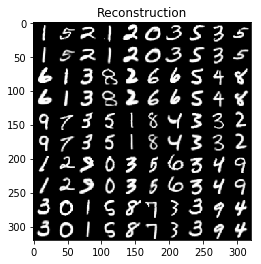

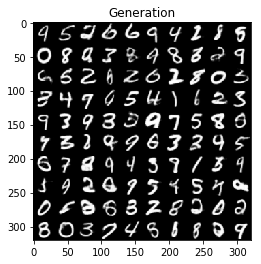

In [16]:
sess.run(init_op)
start_time = time.time()
for i in range(1, nb_steps+1):
    x_np = next(train_batches)
    _, loss_np, ll_np, kl_np = sess.run([train_vae_op, loss, loglikelihood, kl], feed_dict={x: x_np})
    if i % 1000 == 0:
        end_time = time.time()
        print('Step: {:d} in {:.2f}s :: Loss: {:.3f} => Recons.: {:.3f}, KL: {:.3f}'.format(i, end_time - start_time, loss_np, -ll_np, kl_np))
        start_time = end_time
    if i % 10000 == 0:
        x_test_np = next(test_batches)
        x_recons_np = sess.run(x_recons, feed_dict={x_test: x_test_np})
        plot_reconstructions(x_test_np, x_recons_np)
        z_noise_np = np.random.randn(100, z_dim)
        x_fake_np = sess.run(x_fake, feed_dict={z_noise: z_noise_np})
        render_images(x_fake_np)

## Generation from $\mathcal{N}(\mathbf{0},\mathbf{I})$

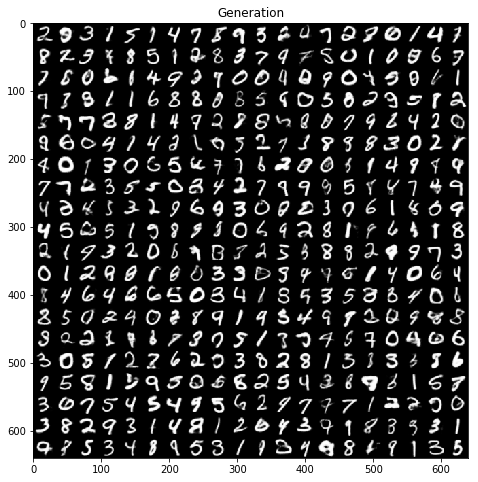

In [17]:
z_noise_np = np.random.randn(20 * 20, z_dim)
x_fake_np = sess.run(x_fake, feed_dict={z_noise: z_noise_np})
render_images(x_fake_np, n_rows=20, figsize=[8, 8])